In [ ]:
'''
Dynamic pricing - curtailment_rate (19x16)
PAR ----
priorities ----
'''

'\nDynamic pricing - curtailment_rate (19x16)\nPAR ----\npriorities ----\n'

In [ ]:
#imports
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
load_df = pd.read_csv("/content/drive/MyDrive/dataset/load_characteristics.csv")
curtailment_df = pd.read_csv("/content/drive/MyDrive/dataset/required_curtailment.csv")

In [ ]:
load_df

,IL No,Capacity,Rate,Max_off,Min_on
0,1,320,23.8,4,2
1,2,200,25.7,4,2
2,3,80,16.9,4,2
3,4,84,16.9,4,2
4,5,100,19.2,4,2
5,6,160,23.6,4,2
6,7,100,19.2,3,1
7,8,60,16.9,3,1
8,9,200,25.7,3,1
9,10,40,16.9,4,1


In [ ]:
capacities = list(load_df["Capacity"])
curtailment_rate = list(load_df["Rate"])

In [ ]:
curtailment_df

,Hour,curtailment_A,curtailment_B
0,1,0,113.8
1,2,0,227.5
2,3,0,455.0
3,4,0,682.5
4,5,444,773.5
5,6,430,796.3
6,7,436,750.8
7,8,0,637.0
8,9,336,591.5
9,10,797,609.7


In [ ]:
priority = np.array([1, 1, 2, 2, 3, 1, 2, 3, 2, 3, 2, 2, 3, 1, 1, 3, 3, 1, 1])
print(priority.shape)

(19,)


In [ ]:
curtailment_A = np.array(curtailment_df["curtailment_A"])

In [ ]:
curtailment_B = np.array(curtailment_df["curtailment_B"])

In [ ]:
Max_off = np.array(load_df["Max_off"])
Min_on = np.array(load_df["Min_on"])

In [ ]:
'''
SEPARATE EXCESS AND UNDER CURTAILMENT
'''

def fitness_func(p, N, T, capacity, curtailment_rate):
  sch = p.x
  s1 = 0
  curtailment_count = np.zeros(N)
  UC = 0

  for t in range(T):

    hour_curtailment = 0
    curtailment_count = np.add(curtailment_count , np.array(sch[t]))

    for n in range(N):
      s1 += sch[t][n]*capacity[n]*curtailment_rate[n]*(4-priority[n])
      hour_curtailment += capacity[n]*sch[t][n]

    if hour_curtailment < curtailment_A[t]:
      UC += 1

  curtailment_count = curtailment_count.astype(int).tolist()

  curtailment_freq = [0 for _ in range(T+1)]

  for c in curtailment_count:
    for j in range(c+1):
      curtailment_freq[j] += 1

  s2 = 0
  for i in range(2, T+1):
    s2 += (2**(i-2))*curtailment_freq[i]

  V = 0

  for i in range(N):
    off_hours = curtailment_count[i]
    on_hours = T-off_hours

    if off_hours > Max_off[i] or on_hours < Min_on[i]:
      V += 1

  s2 *= 1000

  UC *= 10000000

  #Implement PAR -----------------------

  peak_load = -float("inf")
  avg_load = 0

  for i in range(T):
    hourly_load = 0

    for j in range(N):
      if sch[i][j] == 0:
        hourly_load += capacity[n]

    if hourly_load > peak_load:
      peak_load = hourly_load

    avg_load += hourly_load

  avg_load /= T
  avg_load += 1

  PAR = 10000*(peak_load/avg_load)

  # -----------------------------------



  # ADDITIONAL CONSTRAINTS IMPLEMENTATION

  over = 0
  under = 0

  for i in range(N):
    off_hours = curtailment_count[i]
    on_hours = T-off_hours

    if off_hours > Max_off[i] or on_hours < Min_on[i]:
      over += off_hours - Max_off[i]

    if on_hours < Min_on[i]:
      under += Min_on[i] - on_hours

  over *= 100000
  under *= 1000
  # return -(s1 + s2 + UC + V)
  return -(s1 + s2 + UC + over + under)

#***BPSO***

In [ ]:
class Particle:
  def __init__(self, n, t, id = None, show_update=False):

    self.show_update = show_update
    self.id = id
    self.n = n
    self.t = t
    self.x = np.array([[random.choice([0,1]) for _ in range(self.n)] for __ in range(t)])
    self.v = np.array([[random.uniform(-5, 5) for _ in range(self.n)] for __ in range(t)]).astype('float64')
    self.fitness = fitness_func(self, self.n, self.t, capacities, curtailment_rate)

    self.p_best = self.x.copy()
    self.p_best_fitness = self.fitness

  def update_vel_pos(self, G_best_x):
    inertia = 1
    cognitive_coeff = 7.5
    social_coeff = 7.5
    v_max = 5
    threshold = random.random()
    # print(self.v.dtype)

    r1 = np.random.random((16, 19))
    r2 = np.random.random((16, 19))

    # r1 = random.random()
    # r2 = random.random()
    self.v = inertia*self.v + (cognitive_coeff*r1*(np.subtract(self.p_best, self.x)) + social_coeff*r2*(np.subtract(G_best_x, self.x)))
    self. v = np.clip(self.v, -v_max, v_max)
    # print(self.v)
    v_sigm = 1/(1+np.exp(-self.v))


    self.x = np.where(v_sigm>threshold, 1, 0)

  def compare_bests(self, G_best_score):
    self.fitness = fitness_func(self, self.n, self.t, capacities, curtailment_rate)
    if self.fitness > self.p_best_fitness:
      if self.fitness == 0:
        print("found 0 solution")
      self.p_best = self.x.copy()
      self.p_best_fitness = self.fitness
      if self.id:
        print(f"{self.id} found a better solution")

    if self.p_best_fitness > G_best_score:
      return (True, self.p_best, self.p_best_fitness)
    else:
      return (False, None, None)

In [ ]:
P = Particle(19, 16)
print(P.x)

[[1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 0]
 [1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1]
 [1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0]
 [0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1]
 [1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 0 0]
 [0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1]
 [0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0]
 [0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1]
 [1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1]
 [1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1]
 [1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0]
 [0 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0]
 [0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0]
 [0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1]
 [1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0]]


In [ ]:
fitness_func(P, P.n, P.t, capacities, curtailment_rate)

-16001944.8

In [ ]:
print(P.fitness)

-16001944.8


In [ ]:
Max_iter = 100

In [ ]:
swarm = [Particle(19, 16) for _ in range(250)]

In [ ]:
G_best = Particle(19, 16)
G_best_BPSO = G_best.x
G_best_score_BPSO = G_best.fitness

In [ ]:
G_best_score_BPSO

-16933490.4

In [ ]:
import time

In [ ]:
G_best_iters = [G_best_score_BPSO]
avg_iter_time = 0
total_time = time.time()
for T in range(Max_iter):
  # print("ITERATION NUMBER: ",T)
  start = time.time()
  for p in swarm:
    p.update_vel_pos(G_best_BPSO)

  for p in swarm:
    is_better, personal_sol, personal_score = p.compare_bests(G_best_score_BPSO)
    if is_better:
      G_best_BPSO, G_best_score_BPSO = personal_sol, personal_score

  # print(G_best_score_BPSO)
  G_best_iters.append(G_best_score_BPSO)
  avg_iter_time += time.time()-start

total_time = time.time() - total_time
avg_iter_time /= Max_iter
print("Average iteration time is ",avg_iter_time, "secs")
print("Total run time is ", total_time, "secs")

  # print(G_best_score)

Average iteration time is  0.4009395956993103 secs
Total run time is  40.0946364402771 secs


In [ ]:
print(G_best_BPSO)
print(-G_best_score_BPSO)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
152366.0


In [ ]:
G_best_x_BPSO = [list(row) for row in list(G_best_BPSO)]

In [ ]:
G_best_hourly_BPSO = []

for t in range(16):
  curtailed = 0
  for n in range(19):
    curtailed += G_best_x_BPSO[t][n]*capacities[n]

  G_best_hourly_BPSO.append(curtailed)

np.array(G_best_hourly_BPSO)

array([  0,   0,   0,   0, 460, 440, 464,   0, 340, 816, 460, 100,   0,
         0,   0,   0])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
G_best_iters = [-x for x in G_best_iters]

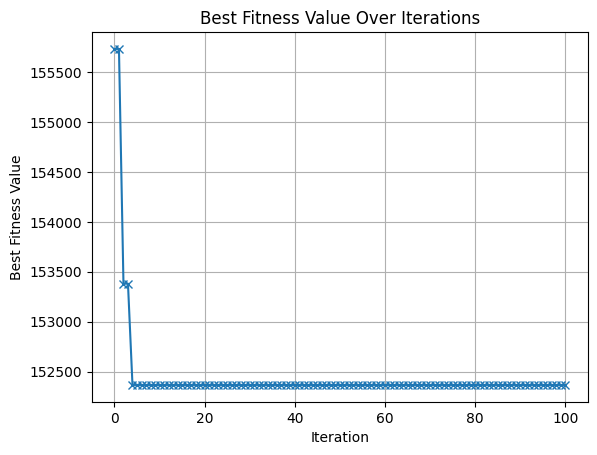

In [ ]:
plt.figure()
plt.plot(range(Max_iter+1), G_best_iters, marker='x', linestyle='-')
plt.title("Best Fitness Value Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness Value")
plt.grid(True)
plt.show()

In [ ]:
off_time_BPSO = []
for j in range(19):
  IL_off = 0
  for i in range(16):
    IL_off += G_best_x_BPSO[i][j]

  off_time_BPSO.append(IL_off)

off_time_BPSO

[1, 2, 3, 2, 1, 1, 2, 0, 1, 2, 1, 1, 0, 0, 1, 2, 3, 1, 0]

In [ ]:
on_time_BPSO = [16-t for t in off_time_BPSO]
on_time_BPSO

[15, 14, 13, 14, 15, 15, 14, 16, 15, 14, 15, 15, 16, 16, 15, 14, 13, 15, 16]

In [ ]:
print("----------------------IL priorities and number of times interrupted----------------------")
priority_curtailment_dict_BPSO = {1:0, 2:0, 3:0}
for i in range(16):
  # print(f"\nIL number {i}: priority {priority[i]}: curtailed {np.sum(G_best_x_BPSO[i])}\n")
  priority_curtailment_dict_BPSO[priority[i]] += np.sum(G_best_x_BPSO[i])

----------------------IL priorities and number of times interrupted----------------------


In [ ]:
priority_curtailment_dict_BPSO

{1: 3, 2: 11, 3: 10}

In [ ]:
BPSO_hourly_cost = []
T = 16
N = 19
for t in range(T):
  hourly_cost = 0
  for n in range(N):
    hourly_cost += G_best_BPSO[t][n]*capacities[n]*curtailment_rate[n]*(4-priority[n])
  BPSO_hourly_cost.append(hourly_cost)
    # hour_curtailment += capacities[n]*sch[t][n]


In [ ]:
peak_load = -float("inf")
avg_load = 0
T = 16
N = 19
for i in range(T):
  hourly_load = 0

  for j in range(N):
    if G_best_BPSO[i][j] == 0:
      hourly_load += capacities[j]

  if hourly_load > peak_load:
    peak_load = hourly_load

  avg_load += hourly_load

avg_load /= T
avg_load += 1

PAR_BPSO = (peak_load/avg_load)

#***Differential Evolution***

In [ ]:
'''
EXTRA CURTAILMENT CONSTRAINT
OPERATIONAL DURATION
'''

def obj_func(sol, N, T, capacity, curtailment_rate):

  sch = sol
  s1 = 0
  curtailment_count = np.zeros(N)
  UC = 0
  for t in range(T):

    hour_curtailment = 0
    curtailment_count = np.add(curtailment_count , np.array(sch[t]))
    for n in range(N):
      s1 += sch[t][n]*capacity[n]*curtailment_rate[n]*(4-priority[n])
      hour_curtailment += capacity[n]*sch[t][n]

    if hour_curtailment < curtailment_A[t]:
      UC += 1

  curtailment_count = curtailment_count.astype(int).tolist()

  curtailment_freq = [0 for _ in range(T+1)]

  for c in curtailment_count:
    for j in range(c+1):
      curtailment_freq[j] += 1

  s2 = 0
  for i in range(2, T+1):
    s2 += (2**(i-2))*curtailment_freq[i]


  s2 *= 1000

  UC *= 10000000

  #Implement PAR -----------------------

  peak_load = -float("inf")
  avg_load = 0

  for i in range(T):
    hourly_load = 0

    for j in range(N):
      if sch[i][j] == 0:
        hourly_load += capacity[n]

    if hourly_load > peak_load:
      peak_load = hourly_load

    avg_load += hourly_load

  avg_load /= T
  avg_load += 1

  PAR = 10000*(peak_load/avg_load)

  # -----------------------------------


  # ADDITIONAL CONSTRAINTS IMPLEMENTATION

  over = 0
  under = 0

  for i in range(N):
    off_hours = curtailment_count[i]
    on_hours = T-off_hours

    if off_hours > Max_off[i]:
      over += off_hours - Max_off[i]

    if on_hours < Min_on[i]:
      under += Min_on[i] - on_hours

  over *= 100000
  under *= 100000
  return -(s1 + s2 + UC + over + under)

In [ ]:
import random
import numpy as np

matrix_size = (16,19)  # Size of the 2D matrix
population_size = 20  # Number of solns
max_iterations = 100  # Max number of iterations
cr = 0.8  # Crossover rate
f = 0.5   # Differential weight
population = []


# Initialize the population
for _ in range(population_size):
    solution = np.random.choice([0, 1], size=matrix_size)
    population.append(solution)

# Main Differential Evolution loop
total_time = time.time()
avg_iter_time = 0
for iteration in range(max_iterations):
    avg_iter_time -= time.time()
    new_population = []

    for i in range(population_size):
        a, b, c = random.sample(population, 3)

        trial_solution = population[i].copy()
        for j in range(matrix_size[0]):
            for k in range(matrix_size[1]):
                if random.random() < cr or j == random.randint(0, matrix_size[0] - 1):
                    trial_solution[j, k] = int(a[j, k] + f * (b[j, k] - c[j, k]))

        trial_fitness = obj_func(trial_solution, 19, 16, capacities, curtailment_rate)
        current_fitness = obj_func(population[i], 19, 16, capacities, curtailment_rate)

        if trial_fitness >= current_fitness:
            new_population.append(trial_solution)
        else:
            new_population.append(population[i])

    population = new_population
    avg_iter_time += time.time()

total_time = time.time() - total_time
avg_iter_time /= max_iterations
# Find the best solution in the population
best_fitness = -float("inf")
best_solution = None

for x in population:
  fitness = obj_func(x, 19, 16, capacities, curtailment_rate)
  if fitness > best_fitness:
    best_solution = x
    best_fitness = fitness

print("Best solution:")
print(best_solution)
print("Best fitness:", -best_fitness)  # Convert back to positive value
print("Average iteration time is ",avg_iter_time, "secs")
print("Total run time is ", total_time, "secs")


Best solution:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Best fitness: 201868.0
Average iteration time is  0.09990335464477539 secs
Total run time is  9.9911789894104 secs


In [ ]:
G_best_DE = best_solution
G_best_score_DE = -best_fitness

In [ ]:
G_best_x_DE = [list(row) for row in list(G_best_DE)]

In [ ]:
off_time_DE = []
for j in range(19):
  IL_off = 0
  for i in range(16):
    IL_off += G_best_x_DE[i][j]

  off_time_DE.append(IL_off)

off_time_DE

[3, 3, 1, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 3, 0, 2, 1, 0, 1]

In [ ]:
on_time_DE = [16-t for t in off_time_DE]
on_time_DE

[13, 13, 15, 14, 15, 15, 16, 16, 14, 16, 15, 15, 16, 13, 16, 14, 15, 16, 15]

In [ ]:
print("----------------------IL priorities and number of times interrupted----------------------")
priority_curtailment_dict_DE = {1:0, 2:0, 3:0}
for i in range(16):
  # print(f"\nIL number {i}: priority {priority[i]}: curtailed {np.sum(G_best_x_DE[i])}\n")
  priority_curtailment_dict_DE[priority[i]] += np.sum(G_best_x_DE[i])

----------------------IL priorities and number of times interrupted----------------------


In [ ]:
priority_curtailment_dict_DE

{1: 4, 2: 10, 3: 8}

In [ ]:
G_best_hourly_DE = []

for t in range(16):
  curtailed = 0
  for n in range(19):
    curtailed += G_best_x_DE[t][n]*capacities[n]

  G_best_hourly_DE.append(curtailed)

np.array(G_best_hourly_DE)

array([  0,  84,   0,   0, 460, 484, 572,   0, 360, 860, 480,  80,  40,
         0,   0,   0])

In [ ]:
DE_hourly_cost = []
T = 16
N = 19
for t in range(T):
  hourly_cost = 0
  for n in range(N):
    hourly_cost += G_best_DE[t][n]*capacities[n]*curtailment_rate[n]*(4-priority[n])
  DE_hourly_cost.append(hourly_cost)
    # hour_curtailment += capacities[n]*sch[t][n]


In [ ]:
peak_load = -float("inf")
avg_load = 0
T = 16
N = 19
for i in range(T):
  hourly_load = 0

  for j in range(N):
    if G_best_DE[i][j] == 0:
      hourly_load += capacities[j]

  if hourly_load > peak_load:
    peak_load = hourly_load

  avg_load += hourly_load

avg_load /= T
avg_load += 1

PAR_DE = (peak_load/avg_load)

#***Harmonic Memory Search***

In [ ]:
import random
import numpy as np

matrix_size = (16, 19)  # Size of the 2D matrix
harmony_memory_size = 10  # Size of the harmony memory
max_iterations = 100  # Maximum number of iterations
harmony_memory = []

HMCR = 0.2 #Harmonic memory consideration
PAR = 0.5 #Pitch adjustment rate

# Initialize the harmony memory with random binary matrices
for _ in range(harmony_memory_size):
    solution = np.random.choice([0, 1], size=matrix_size)
    harmony_memory.append(solution)

total_time = time.time()
avg_iter_time = 0

# Main Harmony Search loop
for iteration in range(max_iterations):
    avg_iter_time -= time.time()
    if random.random() <= HMCR:
      new_solution = random.choice(harmony_memory)
      for i in range(matrix_size[0]):
        for j in range(matrix_size[1]):
            if random.random() <= PAR:
                new_solution[i, j] = random.choice([0, 1])
    else:
      new_solution = np.random.choice([0, 1], size=matrix_size)


    # Evaluate the new solution
    new_solution_fitness = -obj_func(new_solution, 19, 16, capacities, curtailment_rate)

    # Find the worst solution in the harmony memory
    worst_fitness = -float("inf")
    worst_index = None

    for i in range(len(harmony_memory)):
      fitness = -obj_func(harmony_memory[i], 19, 16, capacities, curtailment_rate)
      if fitness > worst_fitness:
        worst_fitness = fitness
        worst_index = i

    # Replace the worst solution if the new solution is better
    if new_solution_fitness < worst_fitness:
        # print(new_solution_fitness)
        harmony_memory[worst_index] = new_solution

    avg_iter_time += time.time()

# Find the best solution in the harmony memory
total_time = time.time() - total_time
avg_iter_time /= max_iterations
best_fitness = float("inf")
best_solution = None

for sol in harmony_memory:
  fitness = -obj_func(sol, 19, 16, capacities, curtailment_rate)
  if fitness < best_fitness:
    best_fitness = fitness
    best_solution = sol

print("Best solution:")
print(best_solution)
print("Best fitness:", best_fitness)
print("Average iteration time is ",avg_iter_time, "secs")
print("Total run time is ", total_time, "secs")


Best solution:
[[1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1]
 [1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0]
 [0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1]
 [0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0]
 [1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1]
 [0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0]
 [1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1]
 [1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0]
 [1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0]
 [0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0]
 [0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0]
 [0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1]
 [0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0]
 [1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0]]
Best fitness: 9456108.8
Average iteration time is  0.015032813549041749 secs
Total run time is  1.504028558731079 secs


In [ ]:
G_best_HMS = best_solution
G_best_score_HMS = best_fitness

In [ ]:
G_best_x_HMS = [list(row) for row in list(G_best_HMS)]

In [ ]:
off_time_HMS = []
for j in range(19):
  IL_off = 0
  for i in range(16):
    IL_off += G_best_x_HMS[i][j]

  off_time_HMS.append(IL_off)

off_time_HMS

[8, 4, 7, 7, 5, 9, 7, 6, 7, 8, 9, 9, 9, 8, 6, 7, 6, 8, 5]

In [ ]:
on_time_HMS = [16-t for t in off_time_HMS]
on_time_HMS

[8, 12, 9, 9, 11, 7, 9, 10, 9, 8, 7, 7, 7, 8, 10, 9, 10, 8, 11]

In [ ]:
print("----------------------IL priorities and number of times interrupted----------------------")
priority_curtailment_dict_HMS = {1:0, 2:0, 3:0}
for i in range(16):
  # print(f"\nIL number {i}: priority {priority[i]}: curtailed {np.sum(G_best_x_HMS[i])}\n")
  priority_curtailment_dict_HMS[priority[i]] += np.sum(G_best_x_HMS[i])
priority_curtailment_dict_HMS

----------------------IL priorities and number of times interrupted----------------------


{1: 54, 2: 42, 3: 39}

In [ ]:
G_best_hourly_HMS = []

for t in range(16):
  curtailed = 0
  for n in range(19):
    curtailed += G_best_x_HMS[t][n]*capacities[n]

  G_best_hourly_HMS.append(curtailed)

np.array(G_best_hourly_HMS)

array([1024, 1892,  960,  880,  652, 1452, 1016, 1296,  912, 1144,  760,
        580,  636, 1176,  840, 1076])

In [ ]:
HMS_hourly_cost = []
T = 16
N = 19
for t in range(T):
  hourly_cost = 0
  for n in range(N):
    hourly_cost += G_best_HMS[t][n]*capacities[n]*curtailment_rate[n]*(4-priority[n])
  HMS_hourly_cost.append(hourly_cost)
    # hour_curtailment += capacities[n]*sch[t][n]


In [ ]:
peak_load = -float("inf")
avg_load = 0
T = 16
N = 19
for i in range(T):
  hourly_load = 0

  for j in range(N):
    if G_best_HMS[i][j] == 0:
      hourly_load += capacities[j]

  if hourly_load > peak_load:
    peak_load = hourly_load

  avg_load += hourly_load

avg_load /= T
avg_load += 1

PAR_HMS = (peak_load/avg_load)

#***RESULTS COMPARISION***

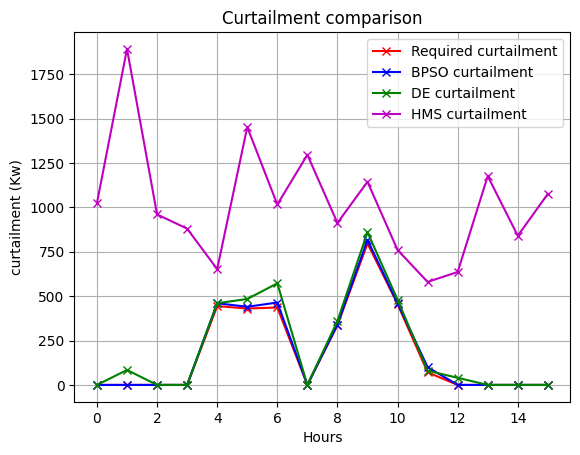

In [ ]:
plt.figure()
plt.plot(curtailment_A, marker='x', linestyle='-', color="r", label="Required curtailment")
plt.plot(G_best_hourly_BPSO, marker='x', linestyle='-', color="b", label="BPSO curtailment")
plt.plot(G_best_hourly_DE, marker='x', linestyle='-', color="g", label="DE curtailment")
plt.plot(G_best_hourly_HMS, marker='x', linestyle='-', color="m", label="HMS curtailment")
plt.title("Curtailment comparison")
plt.xlabel("Hours")
plt.ylabel("curtailment (Kw)")
plt.grid(True)
plt.legend()
plt.show()

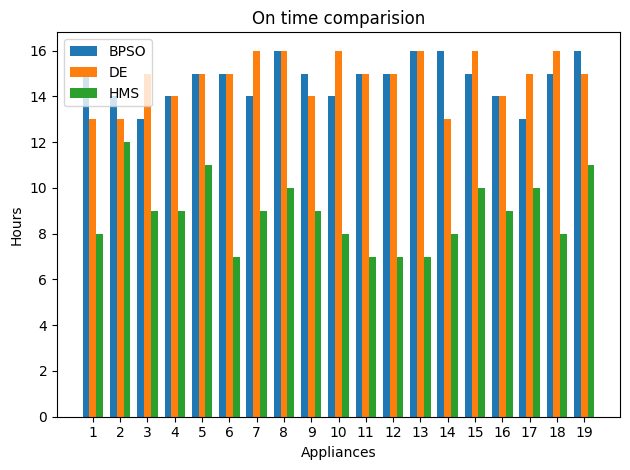

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample labels for the x-axis (replace these with your labels)
labels = [f'{i+1}' for i in range(19)]

# Set the width of the bars
bar_width = 0.25

# Calculate the position of each bar on the x-axis
x = np.arange(len(labels))

# Create the bar graphs for each dataset
plt.bar(x - bar_width, on_time_BPSO, bar_width, label='BPSO')
plt.bar(x, on_time_DE, bar_width, label='DE')
plt.bar(x + bar_width, on_time_HMS, bar_width, label='HMS')

# Set x-axis labels
plt.xticks(x, labels)

# Add a legend
plt.legend()

# Set labels and title
plt.xlabel('Appliances')
plt.ylabel('Hours')
plt.title('On time comparision')

# Show the plot
plt.tight_layout()
# plt.grid(True)
plt.show()


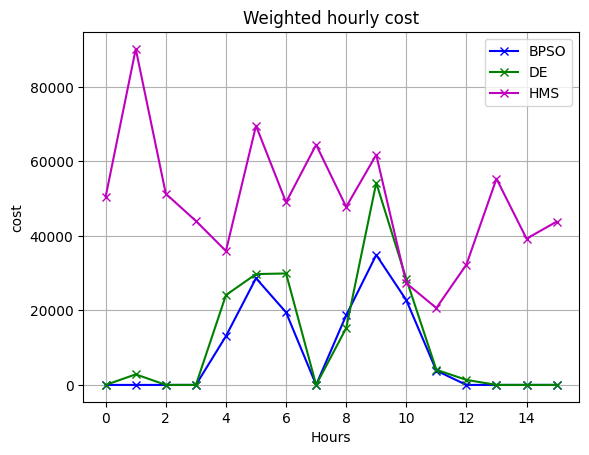

In [ ]:
plt.figure()
# plt.plot(curtailment_A, marker='x', linestyle='-', color="r", label="Required curtailment")
plt.plot(BPSO_hourly_cost, marker='x', linestyle='-', color="b", label="BPSO")
plt.plot(DE_hourly_cost, marker='x', linestyle='-', color="g", label="DE")
plt.plot(HMS_hourly_cost, marker='x', linestyle='-', color="m", label="HMS")
plt.title("Weighted hourly cost")
plt.xlabel("Hours")
plt.ylabel("cost")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print("Peak to average ratios:")
print("BPSO:", PAR_BPSO)
print("DE:", PAR_DE)
print("HMS:", PAR_HMS)

Peak to average ratios:
BPSO: 1.0909954858636255
DE: 1.1021240849633986
HMS: 1.342197888150176
